#Spline interpolation. Technical implementation#

Alnura Abdyrova, Bence Por, Mariia Avdokhina

## Revisiting the Lagrange interpolation problem from Homework 1 ##


In [184]:
#imports
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.interpolate import lagrange, CubicSpline
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error

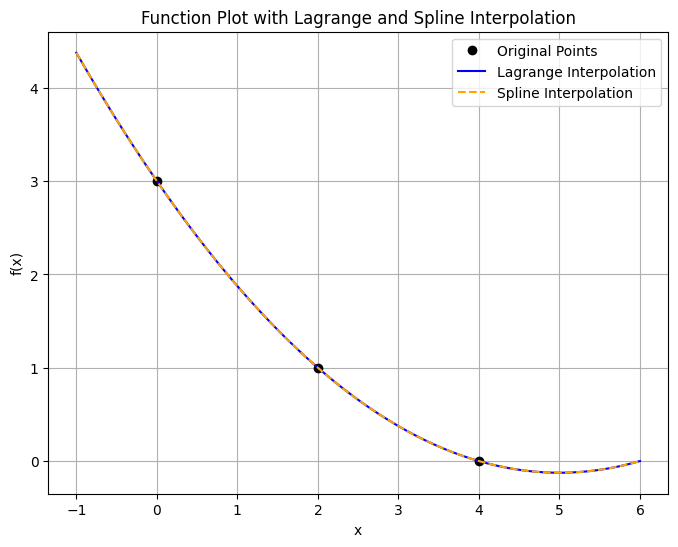

In [185]:
# function to plot
def f(x):
    return (x**2 - 10*x + 24) / 8

# x values (sampling points)
x = np.array([0, 2, 4])
# function values
y = f(x)

# Lagrange interpolation using scipy
lagrange_poly = lagrange(x, y)

# Cubic spline interpolation using scipy
spline = CubicSpline(x, y)

# creating fine grid for plotting the interpolated functions
x_fine = np.linspace(-1, 6, 100) # one can make these values larger to see the two curves coincide for bigger intervals too for this example
y_lagrange = lagrange_poly(x_fine)
y_spline = spline(x_fine)

# create the plot
plt.figure(figsize=(8, 6))

# original points
plt.plot(x, y, 'o', label="Original Points", color='black')

# Lagrange interpolation
plt.plot(x_fine, y_lagrange, '-', label="Lagrange Interpolation", color='blue')

# Spline interpolation
plt.plot(x_fine, y_spline, '--', label="Spline Interpolation", color='orange')

# labels and legend
plt.title('Function Plot with Lagrange and Spline Interpolation')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.legend()

# show the plot
plt.grid(True)
plt.show()


In this particular case, the two curves completely coincide; let us proceed to a more interesting real life application.

## Predicting flight data##

In [186]:
# importing flights dataset from seaborn
import seaborn as sns
flights = sns.load_dataset('flights')

In [187]:
# first few rows of the dataset
print(flights.head())

   year month  passengers
0  1949   Jan         112
1  1949   Feb         118
2  1949   Mar         132
3  1949   Apr         129
4  1949   May         121


In [188]:
# print the shape of the dataset
print(flights.shape)

(144, 3)


In this case, our objective is to plot the data with time on the x-axis and passengers on the y-axis. Therefore, we have to reshape our data.

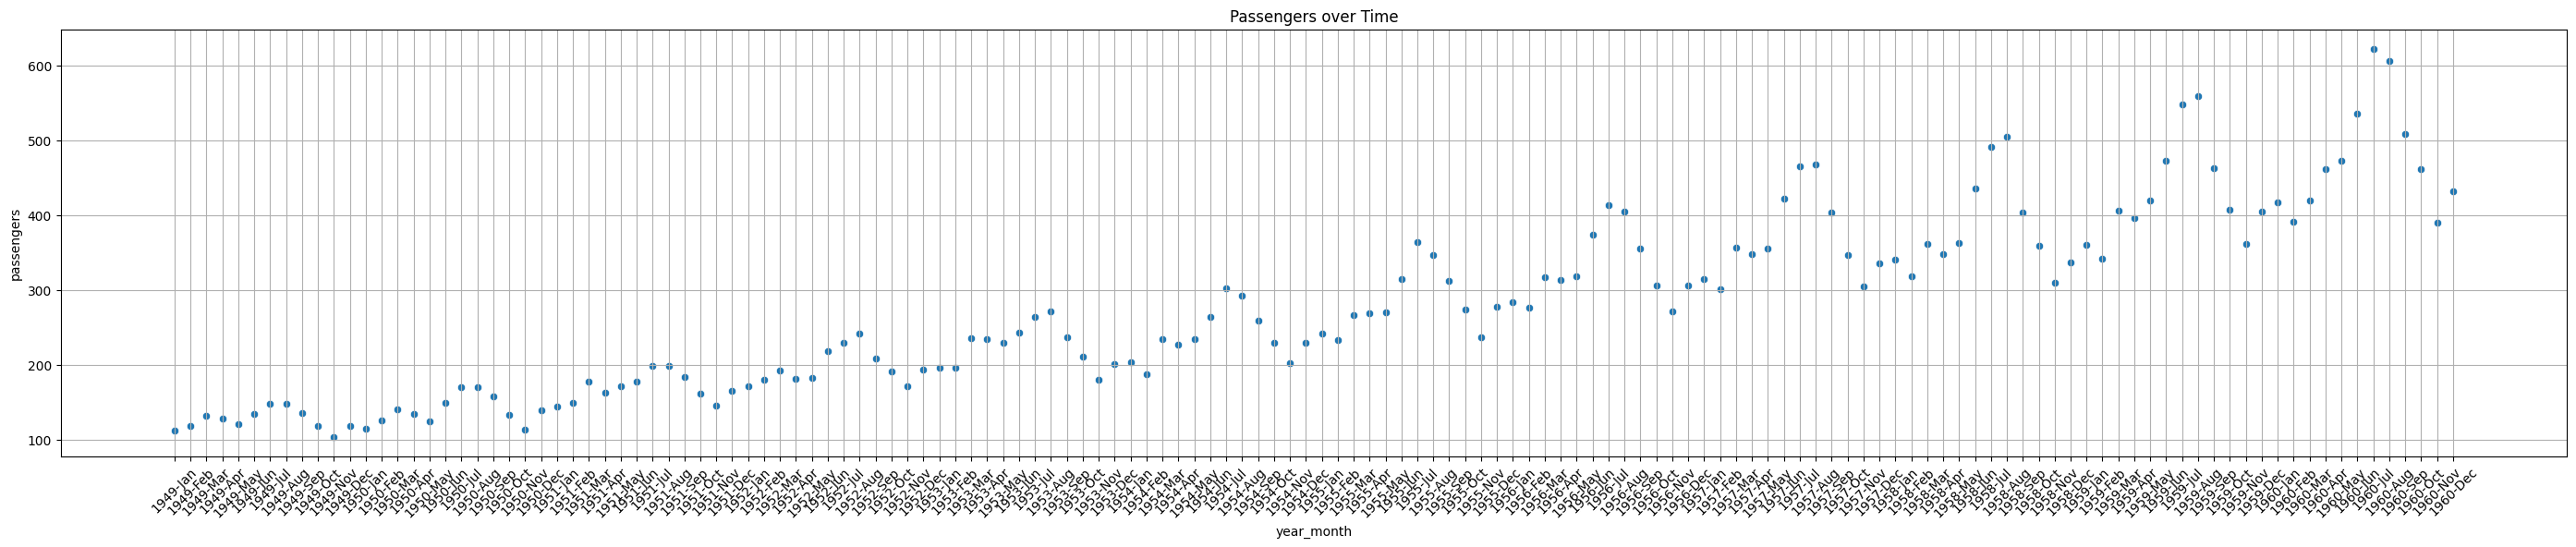

In [189]:
# new data with year month
flights['year'] = flights['year'].astype(str)
flights['month'] = flights['month'].astype(str)
flights['year_month'] = flights['year'] + '-' + flights['month']


# plot scatter plot
plt.figure(figsize=(35, 6))
sns.scatterplot(x='year_month', y='passengers', data=flights)
plt.xticks(rotation=45)
plt.title('Passengers over Time')
plt.grid(True)
plt.show()

We will have to split this data to train and test sets and perform: Lagrange interpolation, linear spline, quadratic spline and different versions of cubic spline on it. We compare the Mean Squared Error to test values and then evaluate the performance of the different methods.


In [190]:
# converting year_month into numeric for the interpolation
flights['time_index'] = np.arange(len(flights))  # Numeric time index
x = flights['time_index']
y = flights['passengers']

# making sure that the first and last data points are in the training set is important for the interpolations later so we exclude those here and add them later to the training set
first_index = x.iloc[0]
last_index = x.iloc[-1]

# create train-test split, excluding the first and last indices temporarily
x_remaining = x.iloc[1:-1]
y_remaining = y.iloc[1:-1]

x_train, x_test, y_train, y_test = train_test_split(x_remaining, y_remaining, test_size=0.35, random_state=42)

# add the first and last points to the training set
x_train = pd.concat([x_train, pd.Series([first_index, last_index])], ignore_index=True)
y_train = pd.concat([y_train, pd.Series([y.iloc[0], y.iloc[-1]])], ignore_index=True)

# ensure sorted order (important for interpolation)
x_train_sorted = np.sort(x_train)
y_train_sorted = y_train.iloc[np.argsort(x_train.values)].values

x_test_sorted = np.sort(x_test)
y_test_sorted = y_test.iloc[np.argsort(x_test.values)].values

In [191]:
# just quickly checking the sets

print(x_train_sorted[:5])
print(y_train_sorted[:5])
print(x_test_sorted[:5])
print(y_test_sorted[:5])

print(min(x_train_sorted), max(x_train_sorted))
print(min(x_test_sorted), max(x_test_sorted))

[0 2 3 4 6]
[112 132 129 121 148]
[ 1  5 10 11 12]
[118 135 104 118 115]
0 143
1 141


In [192]:
# Lagrange Interpolation (just for the sake of demonstration, but with so many data points of course it is going to perform very very very badly)
lagrange_poly = lagrange(x_train_sorted, y_train_sorted)
y_pred_lagrange = lagrange_poly(x_test_sorted)

# Linear Spline
linear_spline = interp1d(x_train_sorted, y_train_sorted, kind='linear')
y_pred_linear = linear_spline(x_test_sorted)

# Quadratic Spline
quadratic_spline = interp1d(x_train_sorted, y_train_sorted, kind='quadratic', fill_value='extrapolate') # extrapolate is necessary for predictiong values outside the range of training data
y_pred_quadratic = quadratic_spline(x_test_sorted)

# Cubic Spline
# Explore different bc_type values
cubic_spline_natural = CubicSpline(x_train_sorted, y_train_sorted, bc_type='natural')
y_pred_cubic_natural = cubic_spline_natural(x_test_sorted)

# Cubic Spline with not-a-knot (Forces third-degree continuity at the second and second to last points)
cubic_spline_not_a_knot = CubicSpline(x_train_sorted, y_train_sorted, bc_type='not-a-knot')
y_pred_cubic_not_a_knot = cubic_spline_not_a_knot(x_test_sorted)


## Plotting the interpolations ##

Lagrange Interpolation

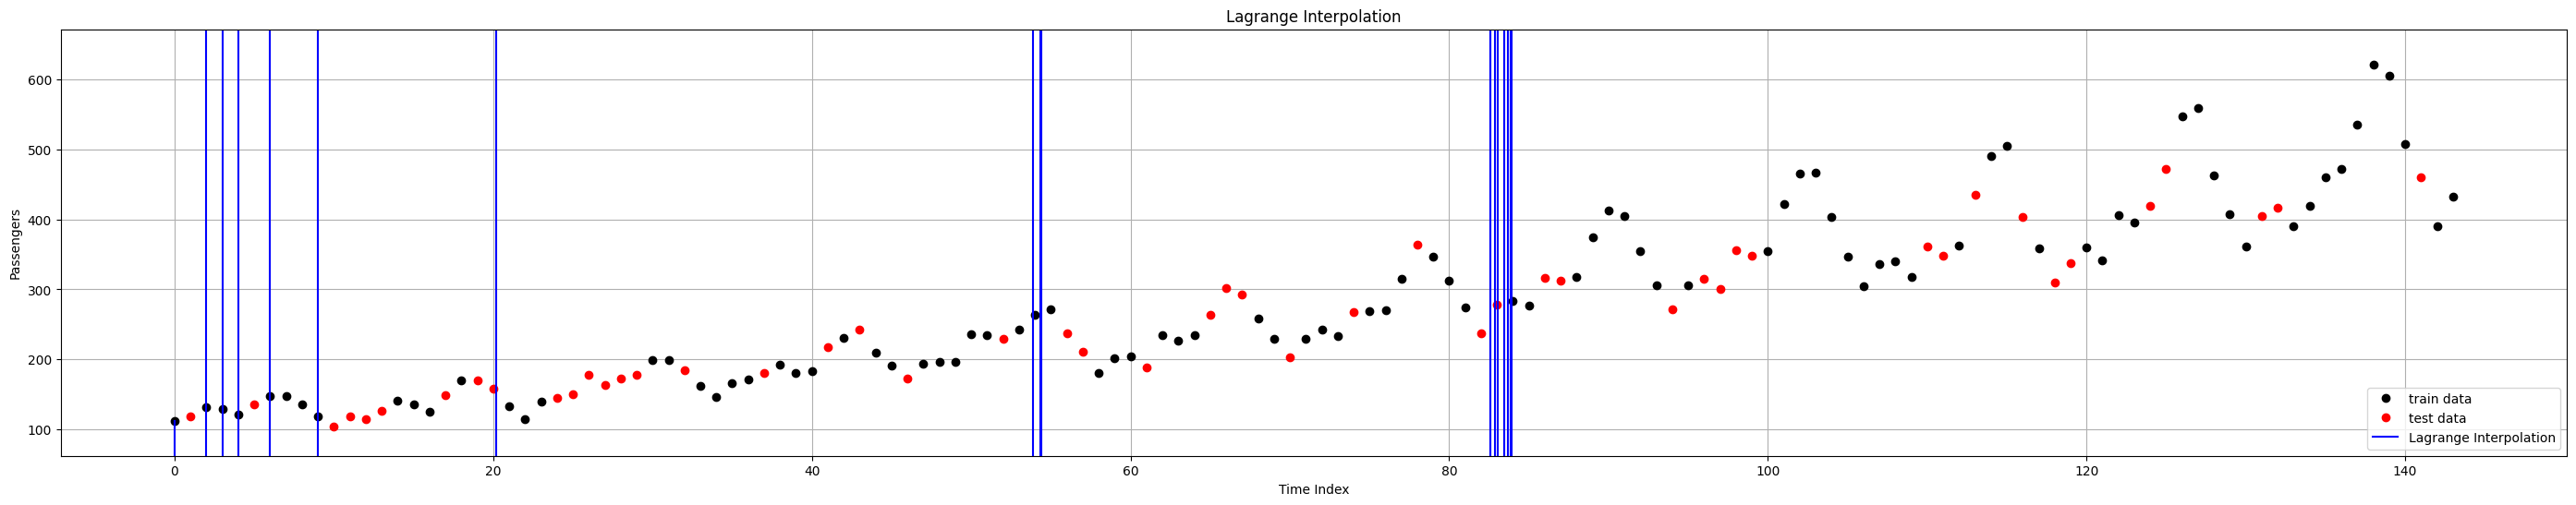

In [193]:
# create the plot
plt.figure(figsize=(35, 6))

# train points
plt.plot(x_train_sorted, y_train_sorted, 'o', label="train data", color='black')

# test points
plt.plot(x_test_sorted, y_test_sorted, 'o', label="test data", color='red')

# Lagrange interpolation
x_fine = np.linspace(min(x_train_sorted), max(x_train_sorted), 1000)  # fine grid for smooth plotting
y_fine_lagrange = lagrange_poly(x_fine)  # evaluating lagrange at x_fine

# plotting
plt.plot(x_fine, y_fine_lagrange, '-', label="Lagrange Interpolation", color='blue')
plt.legend()
plt.title("Lagrange Interpolation")
plt.xlabel("Time Index")
plt.ylabel("Passengers")
plt.ylim([min(y_train_sorted) - 50, max(y_train_sorted) + 50])  # Adjust y-axis range
plt.grid(True)
plt.show()

Plotting the Lagrange polynomial in a meaningful way is a hard task because of Runge's phenomenon. However, using lagrange interpolation with so many data points is a bad idea itself.

Linear Spline

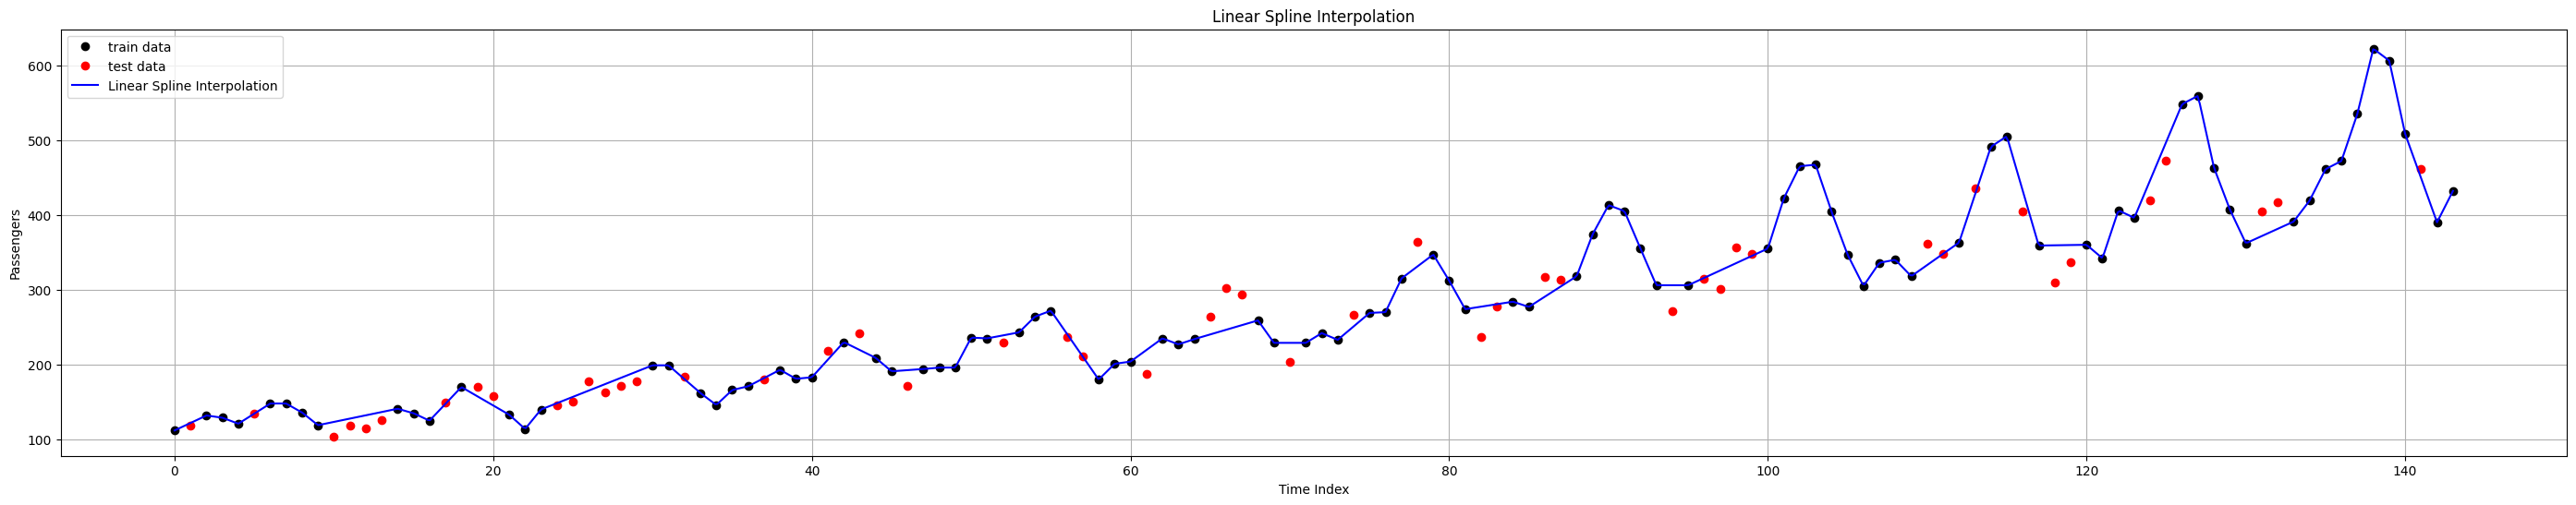

In [194]:
# create the plot
plt.figure(figsize=(35, 6))

# train points
plt.plot(x_train_sorted, y_train_sorted, 'o', label="train data", color='black')

# test points
plt.plot(x_test_sorted, y_test_sorted, 'o', label="test data", color='red')

# linear Spline interpolation
x_fine = np.linspace(min(x_train_sorted), max(x_train_sorted), 1000)  # fine grid for smooth plotting
y_fine_linear = linear_spline(x_fine)  # evaluating the linear spline at x_fine

# plotting
plt.plot(x_fine, y_fine_linear, '-', label="Linear Spline Interpolation", color='blue')
plt.legend()
plt.title("Linear Spline Interpolation")
plt.xlabel("Time Index")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()


Notice that the time on the x-axis is now different. We had 12 years with 12 months each, so we have 12*12=144 months.

Quadratic Spline

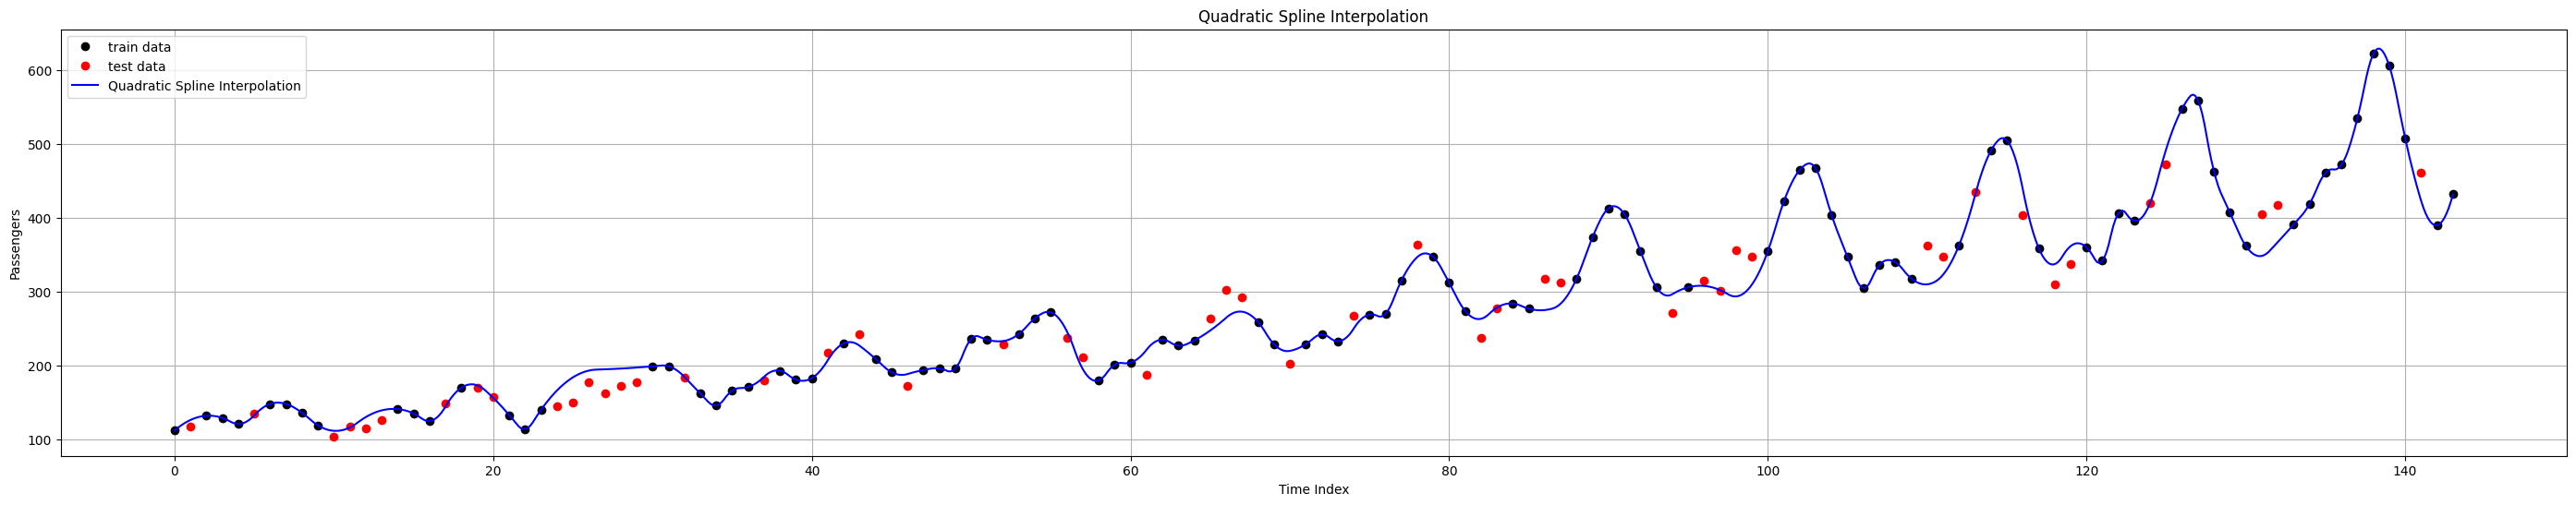

In [195]:
# create the plot
plt.figure(figsize=(35, 6))

# train points
plt.plot(x_train_sorted, y_train_sorted, 'o', label="train data", color='black')

# test points
plt.plot(x_test_sorted, y_test_sorted, 'o', label="test data", color='red')

# quadratic spline interpolation
x_fine = np.linspace(min(x_train_sorted), max(x_train_sorted), 1000)  # fine grid for smooth plotting
y_fine_quadratic = quadratic_spline(x_fine)  # evaluating the quadratic spline at x_fine

# plotting
plt.plot(x_fine, y_fine_quadratic, '-', label="Quadratic Spline Interpolation", color='blue')
plt.legend()
plt.title("Quadratic Spline Interpolation")
plt.xlabel("Time Index")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()


Cubic Spline Interpolation (natural -> assuming that the second derivatives are 0 at the endpoints).

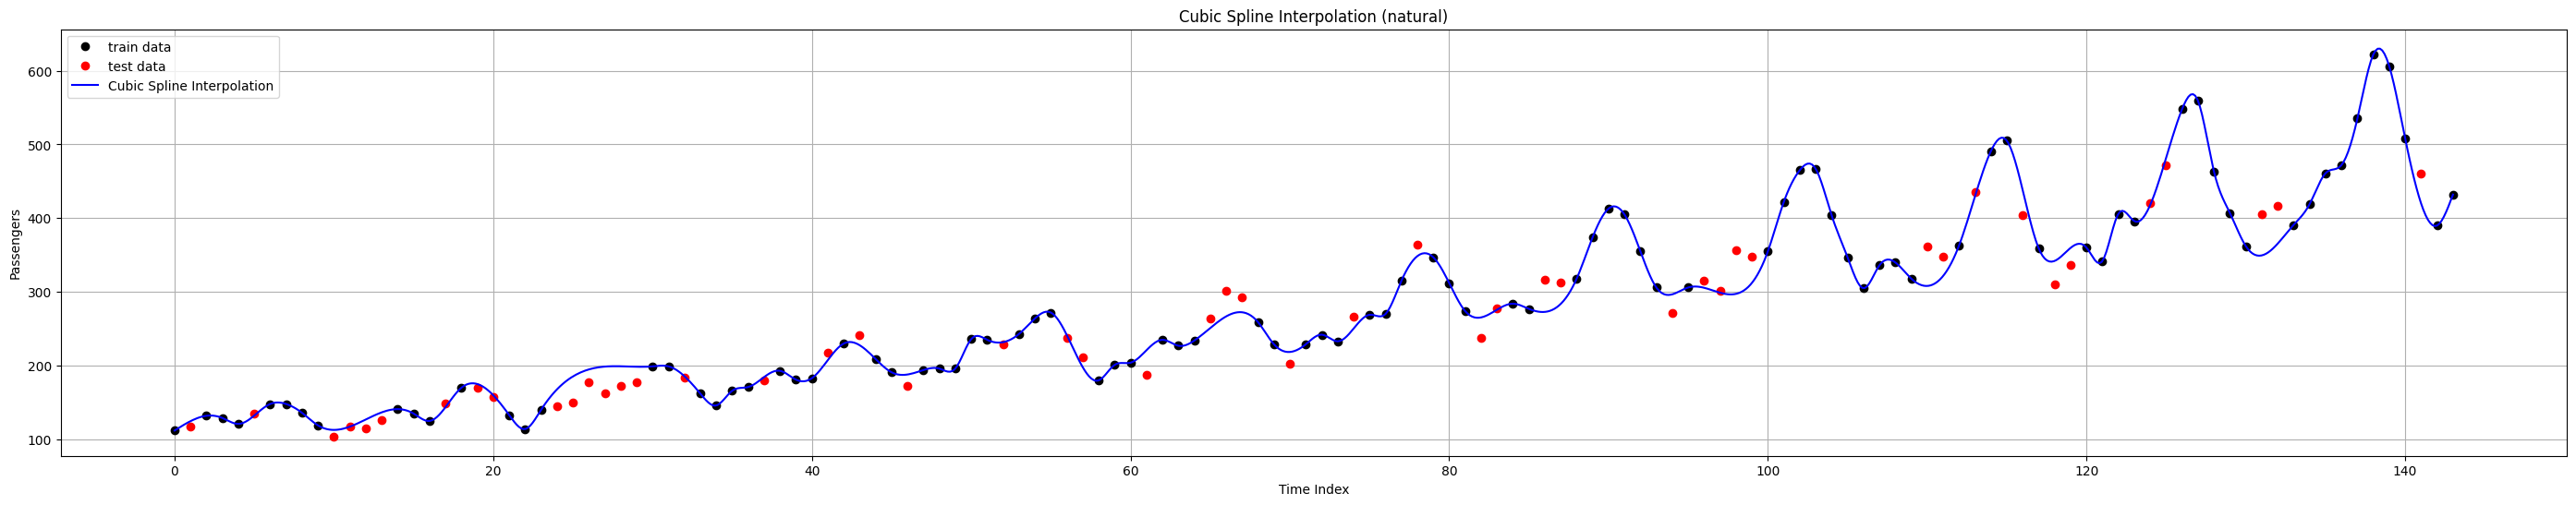

In [196]:
# create the plot
plt.figure(figsize=(35, 6))

# train points
plt.plot(x_train_sorted, y_train_sorted, 'o', label="train data", color='black')

# test points
plt.plot(x_test_sorted, y_test_sorted, 'o', label="test data", color='red')

# cubic spline interpolation (natural)
x_fine = np.linspace(min(x_train_sorted), max(x_train_sorted), 1000)  # fine grid for smooth plotting
y_fine_cubic_natural = cubic_spline_natural(x_fine)  # evaluating the cubic spline at x_fine

# plotting
plt.plot(x_fine, y_fine_cubic_natural, '-', label="Cubic Spline Interpolation", color='blue')
plt.legend()
plt.title("Cubic Spline Interpolation (natural)")
plt.xlabel("Time Index")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()


Cubic Spline (not-a-knot -> forces third-degree continuity at the second and second to last points).

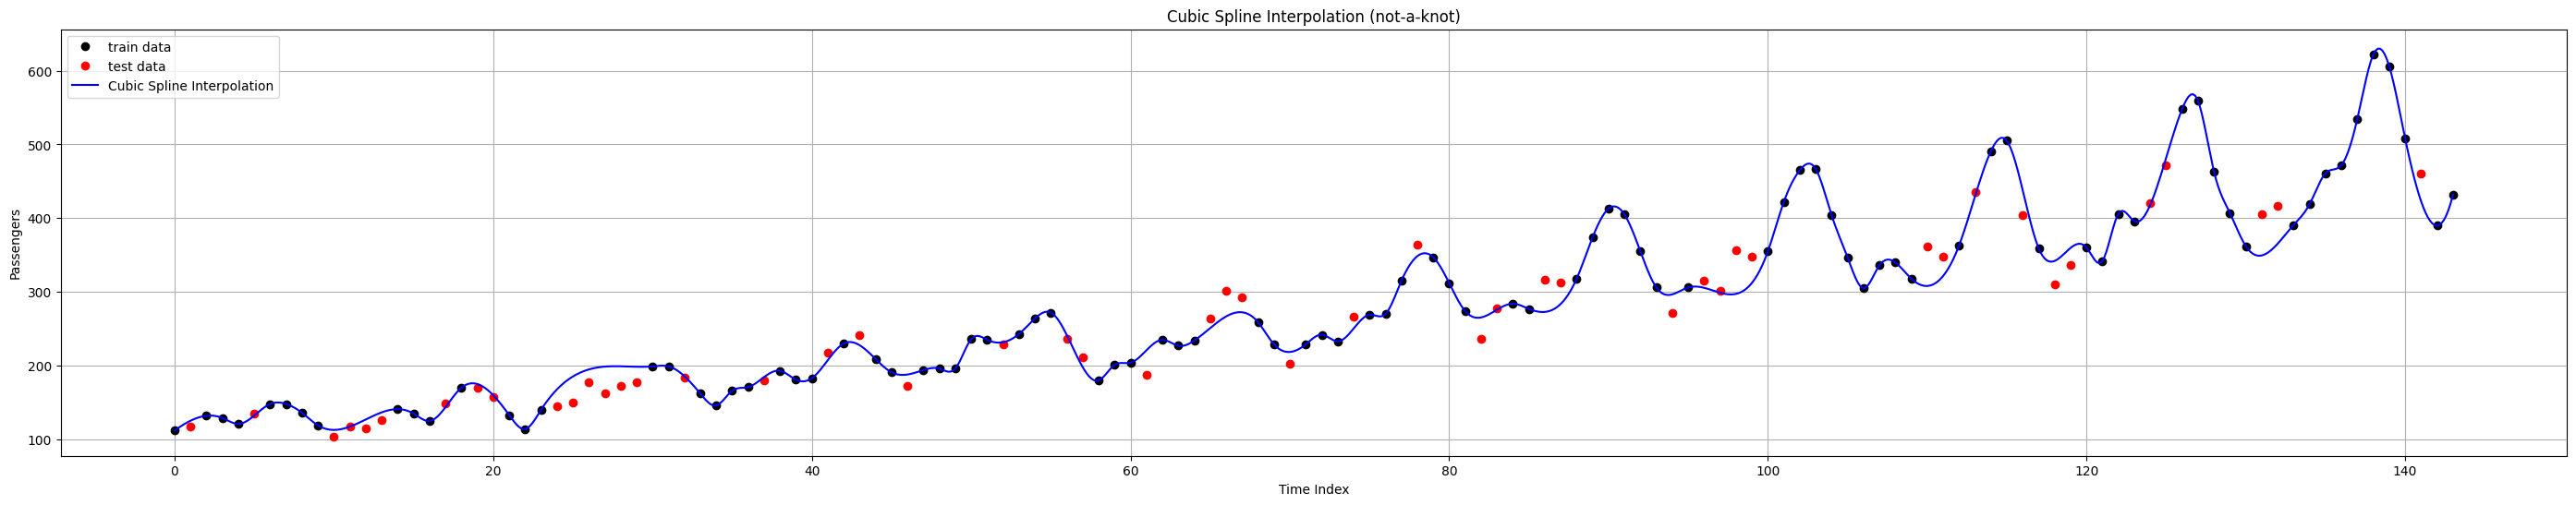

In [197]:
# create the plot
plt.figure(figsize=(35, 6))

# train points
plt.plot(x_train_sorted, y_train_sorted, 'o', label="train data", color='black')

# test points
plt.plot(x_test_sorted, y_test_sorted, 'o', label="test data", color='red')

# Cubic spline interpolation (not-a-knot)
x_fine = np.linspace(min(x_train_sorted), max(x_train_sorted), 1000)  # fine grid for smooth plotting
y_fine_not_a_knot = cubic_spline_not_a_knot(x_fine)  # evaluating the cubic spline at x_fine

# plotting
plt.plot(x_fine, y_fine_not_a_knot, '-', label="Cubic Spline Interpolation", color='blue')
plt.legend()
plt.title("Cubic Spline Interpolation (not-a-knot)")
plt.xlabel("Time Index")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

Here, we only tried the 'not-a-knot' endpoint assumption for cubic spline apart from the natural, but one can easily try the others by setting bc_type='' to any of the other methods.

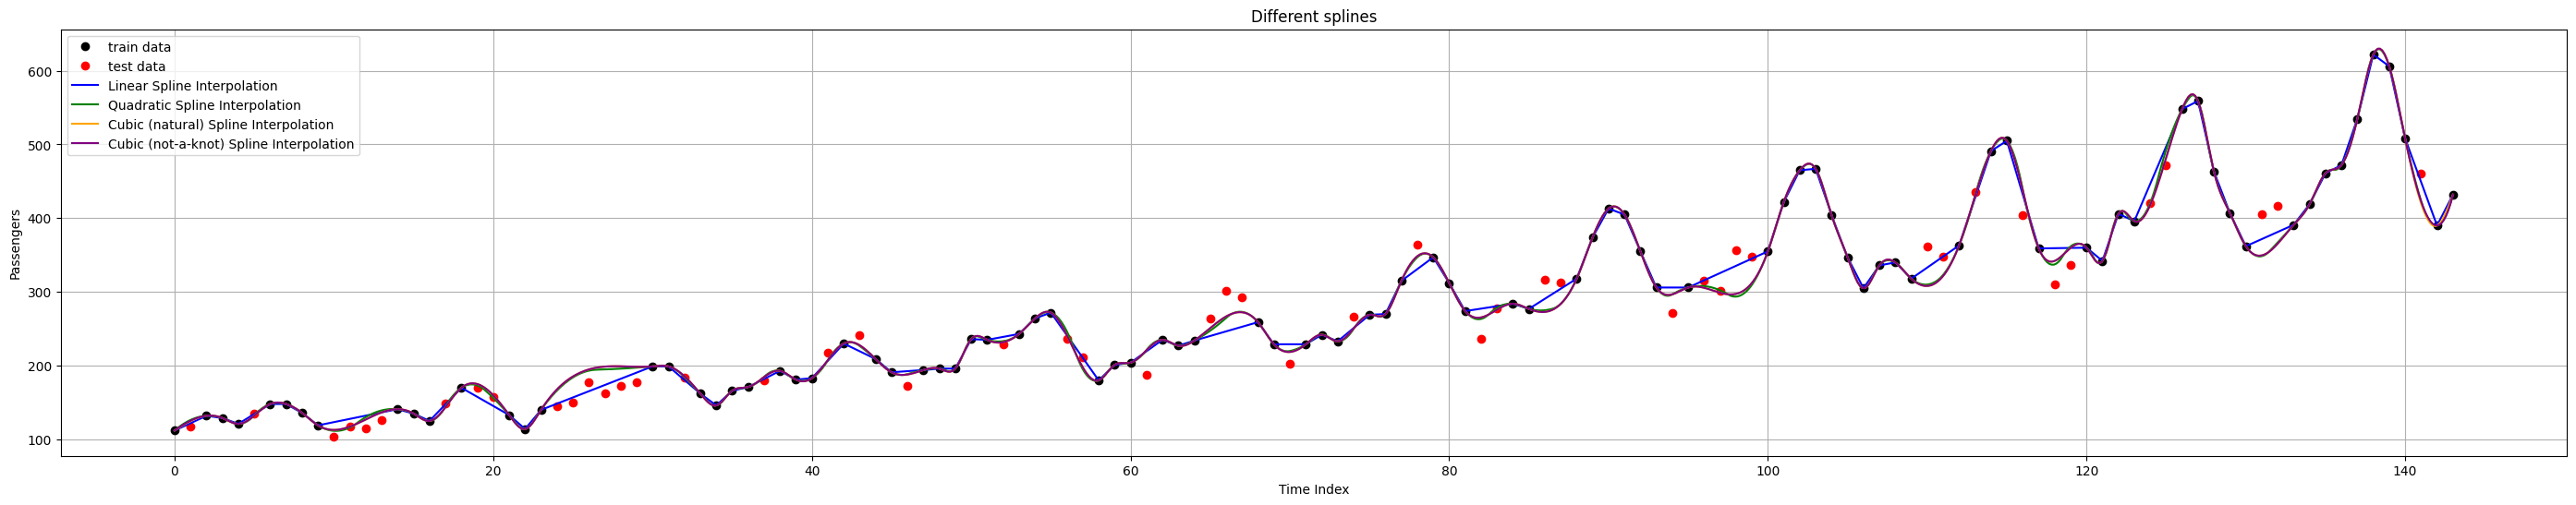

In [198]:
# create the plot
plt.figure(figsize=(35, 6))

# train points
plt.plot(x_train_sorted, y_train_sorted, 'o', label="train data", color='black')

# test points
plt.plot(x_test_sorted, y_test_sorted, 'o', label="test data", color='red')

# plotting
plt.plot(x_fine, y_fine_linear, '-', label="Linear Spline Interpolation", color='blue')
plt.plot(x_fine, y_fine_quadratic, '-', label="Quadratic Spline Interpolation", color='green')
plt.plot(x_fine, y_fine_cubic_natural, '-', label="Cubic (natural) Spline Interpolation", color='orange')
plt.plot(x_fine, y_fine_not_a_knot, '-', label="Cubic (not-a-knot) Spline Interpolation", color='purple')
plt.legend()
plt.title("Different splines")
plt.xlabel("Time Index")
plt.ylabel("Passengers")
plt.grid(True)
plt.show()

In [199]:
# Compute Mean Squared Error
mse_lagrange = mean_squared_error(y_test_sorted, y_pred_lagrange)
mse_linear = mean_squared_error(y_test_sorted, y_pred_linear)
mse_quadratic = mean_squared_error(y_test_sorted, y_pred_quadratic)
mse_cubic_natural = mean_squared_error(y_test_sorted, y_pred_cubic_natural)
mse_cubic_not_a_knot = mean_squared_error(y_test_sorted, y_pred_cubic_not_a_knot)

print("MSE Results:")
print(f"Lagrange: {mse_lagrange}")
print(f"Linear Spline: {mse_linear}")
print(f"Quadratic Spline: {mse_quadratic}")
print(f"Cubic Spline (Natural): {mse_cubic_natural}")
print(f"Cubic Spline (not_a_knot): {mse_cubic_not_a_knot}")


MSE Results:
Lagrange: 1.4178902468419846e+135
Linear Spline: 489.2284682539683
Quadratic Spline: 644.8359748144617
Cubic Spline (Natural): 646.2973103090422
Cubic Spline (not_a_knot): 641.7155617180845


Surprisingly, it seems like the linear spline outperformed every higher degree spline. This is undeniably an exception and not the general case.

## Feature engineering with spline ##
The main idea is the following: synthetic data is created based on the sine function with some noise added. Then, we split the data points to train and test sets. We train a simple decision tree with the train data, predict the test values and evalueate the results with Mean Squared Error.

Afterwards, we generate a cubic spline interpolation based on the train points and store it, as well as the first and second derivatives as new features. Next, we train a new decision tree with these three new features and get a better Mean Squared Error score.

Remark:

It is interesting that if you play with the setting for the synthetic data (for example, make more points) or do not always add all the three new features (you can add just the derivatives or just the spline values), the new model does not always outperform the one with just one feature. It might be because of overfitting to the training data.


In [200]:
import numpy as np
import matplotlib.pyplot as plt

# Generate synthetic data
np.random.seed(42)
#x = x = np.sort(np.random.uniform(0, 10, 50))  # x values
x = x = np.linspace(0, 10, 30)  # x values
y = np.sin(x) + np.random.normal(scale=0.2, size=x.shape)  # Target (sin function with some noise added)


In [201]:
# splitting the data to training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)


In [202]:
# sort the training and test data (for spline later)
sorted_idx_train = np.argsort(x_train)
x_train = x_train[sorted_idx_train]
y_train = y_train[sorted_idx_train]

sorted_idx_test = np.argsort(x_test)
x_test = x_test[sorted_idx_test]
y_test = y_test[sorted_idx_test]

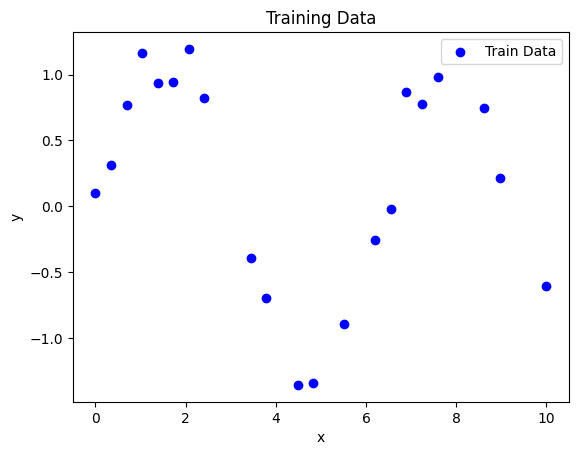

In [203]:
# plotting the train values
plt.scatter(x_train, y_train, label='Train Data', color='blue')
plt.title("Training Data")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()

In [204]:
# training the first model (simple decision tree)

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

# create the model
tree = DecisionTreeRegressor(max_depth=2)

# train the model
tree.fit(x_train.reshape(-1, 1), y_train)

# predict the values
y_test_pred = tree.predict(x_test.reshape(-1, 1))

# calculate the error
test_error = mean_squared_error(y_test, y_test_pred)

print(f"Test Error: {test_error:.2f}")


Test Error: 0.28


In [205]:
# adding features with cubic spline interpolation
from scipy.interpolate import CubicSpline

# create the cubic spline
spline = CubicSpline(x_train, y_train)

# create the new features
x_train_spline = spline(x_train)
derivative_1 = spline.derivative(1)(x_train_spline)  # First derivative
derivative_2 = spline.derivative(2)(x_train_spline)  # Second derivative
# Combine original x_train and spline features into a single array for training
x_train_new = np.array([x_train, x_train_spline, derivative_1, derivative_2]).T


# we add the new spline features to the test set too but the spline was created based on the train points, it does not use the test points so it not data leakage
# create the new features for the test set
x_test_spline = spline(x_test)
test_derivative_1 = spline.derivative(1)(x_test_spline)  # First derivative
test_derivative_2 = spline.derivative(2)(x_test_spline)  # Second derivative
# combining the original and new features
x_test_new = np.array([x_test, x_test_spline, test_derivative_1, test_derivative_2]).T

# create the model
tree = DecisionTreeRegressor(max_depth=2)

# train the model
tree.fit(x_train_new, y_train)

# predict the values
new_y_test_pred = tree.predict(x_test_new)

# calculate the error
new_test_error = mean_squared_error(y_test, new_y_test_pred)

print(f"Test Error: {new_test_error:.2f}")



Test Error: 0.10
